In [10]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, Concatenate, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint






In [11]:
# Load the dataset
df = pd.read_csv('chatgpt_daily_tweets.csv')


In [12]:
# Preprocessing
def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.lower()

df['cleaned_text'] = df['text'].apply(clean_text)
df = df[df['lang'] == 'en']


In [13]:
# Tokenize and pad text
max_len = 100
max_words = 10000

tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=max_len)

In [14]:
from textblob import TextBlob

# Function to get sentiment polarity
def get_sentiment_polarity(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity



In [15]:
# Create a 'sentiment' column based on the polarity score
df['sentiment_polarity'] = df['cleaned_text'].apply(get_sentiment_polarity)
df['sentiment'] = np.where(df['sentiment_polarity'] >= 0, 'positive', 'negative')


In [16]:
# Encode sentiment labels (assuming they exist in the dataset)
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['sentiment'])
labels = labels.reshape(-1, 1)

In [17]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


In [18]:
# Model architecture
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(len(word_index) + 1, 128, input_length=max_len)(input_layer)
x = GlobalMaxPooling1D()(embedding_layer)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)

In [19]:
# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
# Train the model
callbacks = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/10
185/185 [==============================] - 5s 21ms/step - loss: 0.4545 - accuracy: 0.8377 - val_loss: 0.3805 - val_accuracy: 0.8495
Epoch 2/10
185/185 [==============================] - 5s 25ms/step - loss: 0.3196 - accuracy: 0.8465 - val_loss: 0.2450 - val_accuracy: 0.9003
Epoch 3/10
185/185 [==============================] - 4s 20ms/step - loss: 0.1708 - accuracy: 0.9325 - val_loss: 0.1616 - val_accuracy: 0.9566
Epoch 4/10
185/185 [==============================] - 4s 20ms/step - loss: 0.0736 - accuracy: 0.9824 - val_loss: 0.1367 - val_accuracy: 0.9600
Epoch 5/10
185/185 [==============================] - 5s 26ms/step - loss: 0.0401 - accuracy: 0.9932 - val_loss: 0.1349 - val_accuracy: 0.9586
Epoch 6/10
185/185 [==============================] - 4s 21ms/step - loss: 0.0204 - accuracy: 0.9976 - val_loss: 0.1394 - val_accuracy: 0.9600
Epoch 7/10
185/185 [==============================] - 4s 20ms/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.1554 - val_accuracy: 0.9620

In [21]:
# Evaluate the model
score = model.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

47/47 [==============================] - 0s 3ms/step - loss: 0.1631 - accuracy: 0.9620
Test loss: 0.16310246288776398
Test accuracy: 0.9620339274406433


In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, classification_report
import itertools


In [23]:
# Predict the sentiment labels on test data
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)


47/47 [==============================] - 0s 3ms/step


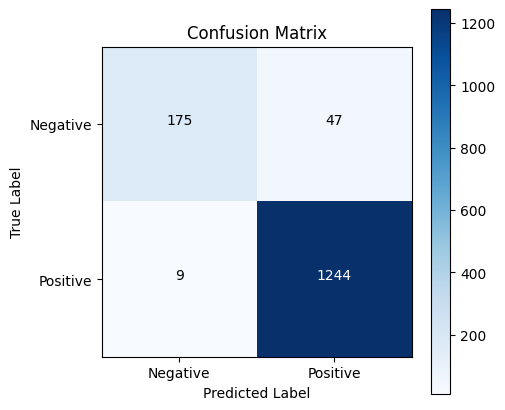

In [24]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Negative', 'Positive'])
plt.yticks(tick_marks, ['Negative', 'Positive'])
thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


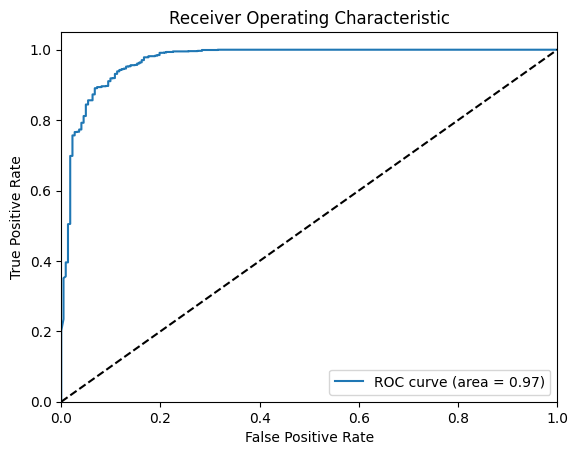

In [25]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


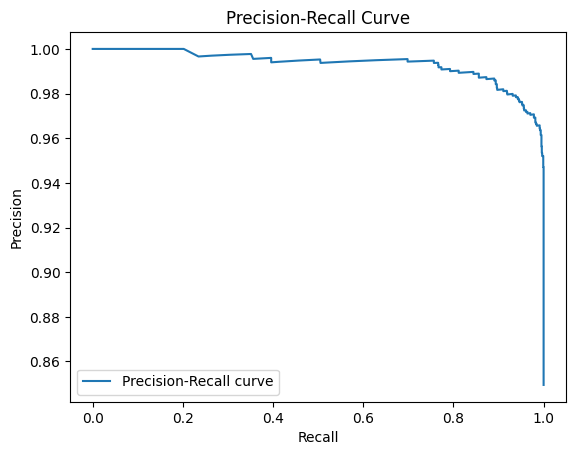

In [26]:
# Precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


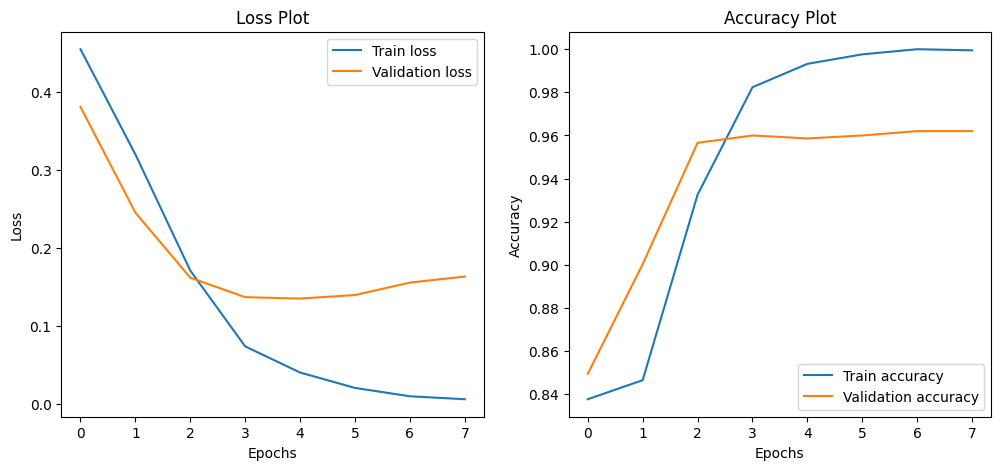

In [27]:
# Loss and accuracy plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Plot')
plt.legend()
plt.show()

In [28]:
# Classification report
print(classification_report(y_test, y_pred_classes, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.95      0.79      0.86       222
    Positive       0.96      0.99      0.98      1253

    accuracy                           0.96      1475
   macro avg       0.96      0.89      0.92      1475
weighted avg       0.96      0.96      0.96      1475

